# Assignment 1

**Credits**: Federico Ruggeri, Eleonora Mancini, Paolo Torroni

**Keywords**: POS tagging, Sequence labelling, RNNs

In [69]:
# TODO remove
# from google.colab import drive
# drive.mount("/content/drive")

import pandas as pd
import numpy as np
from pathlib import Path
import shutil
import urllib
import zipfile

import tqdm
import random
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import text
from tensorflow.keras.preprocessing import sequence
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
)
import os

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, TimeDistributed
from tensorflow.keras.losses import (
    SparseCategoricalCrossentropy,
    CategoricalCrossentropy,
)
from tensorflow.keras.metrics import F1Score
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
from keras.layers import Embedding, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

In [2]:
def set_reproducibility(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    # os.environ["TF_DETERMINISTIC_OPS"] = "1" ### can make training slower


set_reproducibility(seed=42)

# [Task 1 - 0.5 points] Corpus

### Download the corpus

In [3]:
def download_url(download_path: Path, url: str):
    urllib.request.urlretrieve(url, filename=download_path)

In [4]:
dataset_url = "https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip"
dataset_name = "dependency_treebank"

# print(f"Current work directory: {Path.cwd()}")
dataset_folder = Path.cwd().joinpath("Datasets")
if not dataset_folder.exists():
    dataset_folder.mkdir(parents=True)

dataset_zip_path = dataset_folder.joinpath("dependency_treebank.zip")
if not dataset_zip_path.exists():
    print("Downloading dataset... ", end="")
    download_url(url=dataset_url, download_path=dataset_zip_path)
    print("Download complete!")
else:
    print("Dataset already downloaded!")
dataset_path = dataset_folder.joinpath(dataset_name)

if not dataset_path.exists():
    print("Extracting dataset... (it may take a while...) ", end="")
    shutil.unpack_archive(dataset_zip_path, dataset_folder)
    print("Extraction completed!")
else:
    print("Dataset already extracted!")

Extracting dataset... (it may take a while...) Extraction completed!


#### Encode the corpus into a pandas DataFrame object

In [5]:
folder = dataset_folder.joinpath(dataset_name)


dataframe_rows = []
for file_path in sorted(folder.glob("*.dp")):
    with file_path.open(mode="r", encoding="utf-8") as text_file:
        # Reading the text
        text = text_file.read()
        # Split sentences (\n\n is used for most NLP datasets to split sentences)
        sentences = text.split("\n\n")

        # Observing each sentence
        for s in sentences:
            sentence = []
            tags = []
            # sentence = [pierre,vinken,,aksjdajs, ]. tags = [NNP,aab,asd....]
            # Taking every line
            for line in s.split("\n"):
                columns = line.split("\t")
                # If every line have word, tag, value
                if len(columns) > 2:
                    # Put words and tags into lists
                    sentence.append(columns[0])
                    tags.append(columns[1])

            # Get the File_ID
            file_id = int(file_path.stem.split("_")[1])
            dataframe_row = {"file_id": file_id, "sentence": sentence, "tag": tags}
            dataframe_rows.append(dataframe_row)
# Create the dataframe
df = pd.DataFrame(dataframe_rows)

FILE_ID, SENTENCE, TAGS = df.columns.values

In [6]:
df.head()

,file_id,sentence,tag
0,1,"[Pierre, Vinken, ,, 61, years, old, ,, will, j...","[NNP, NNP, ,, CD, NNS, JJ, ,, MD, VB, DT, NN, ..."
1,1,"[Mr., Vinken, is, chairman, of, Elsevier, N.V....","[NNP, NNP, VBZ, NN, IN, NNP, NNP, ,, DT, NNP, ..."
2,2,"[Rudolph, Agnew, ,, 55, years, old, and, forme...","[NNP, NNP, ,, CD, NNS, JJ, CC, JJ, NN, IN, NNP..."
3,3,"[A, form, of, asbestos, once, used, to, make, ...","[DT, NN, IN, NN, RB, VBN, TO, VB, NNP, NN, NNS..."
4,3,"[The, asbestos, fiber, ,, crocidolite, ,, is, ...","[DT, NN, NN, ,, NN, ,, VBZ, RB, JJ, IN, PRP, V..."


#### Splitting Data Train-Test-Validation

In [7]:
### file indices for train/validation/test
train_ids = np.arange(1, 101)
val_ids = np.arange(101, 151)
test_ids = np.arange(151, 200)

df_train = df[df[FILE_ID].isin(train_ids)]
df_val = df[df[FILE_ID].isin(val_ids)]
df_test = df[df[FILE_ID].isin(test_ids)]

# [Task 2 - 0.5 points] Text encoding

To train a neural POS tagger, you first need to encode text into numerical format.

### Instructions

* Embed words using **GloVe embeddings**.
* You are **free** to pick any embedding dimension.
* [Optional] You are free to experiment with text pre-processing: **make sure you do not delete any token!**

In [8]:
### download Glove

embedding_dim = 100
glove_file = f"glove.6B.{embedding_dim}d.txt"
glove_zip = "glove.6B.zip"
glove_path = Path.cwd().joinpath(glove_file)
if not glove_path.exists():
    urllib.request.urlretrieve(
        "http://nlp.stanford.edu/data/glove.6B.zip", Path.cwd().joinpath(glove_zip)
    )
    with zipfile.ZipFile(glove_zip, "r") as zip_ref:
        zip_ref.extractall()

In [9]:
embeddings_index = {}
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print("Found %s word vectors." % len(embeddings_index))

Found 400000 word vectors.


In [10]:
# max_sequence_length = int(np.quantile([len(seq) for seq in df_train["sentence"]], 0.99))
max_sequence_length = max([len(seq) for seq in df_train[SENTENCE]])

# TODO remove
hparams = {
    "batch_size": 128,
    "embedding_dim": 100,
    "embedding_trainable": False,
    "learning_rate": 0.005,
    "max_sequence_length": max_sequence_length,
    "vocab_size": 7405,
    "tag_size": 46,
}

In [11]:
### Preprocessing: lowercase
def make_lower(df):
    df[SENTENCE].apply(lambda l: [i.lower() for i in l])


make_lower(df_train)
make_lower(df_val)
# TODO va bene fare lowercase sul test set? vediamo se va senza
# make_lower(df_test)

In [12]:
### Use Keras Tokenizer to create Vocabulary

# TODO ci hanno consigliato codice deprecato (tokenizer) io vorrei usare TextVectorization ma fa schifo

tokenizer = Tokenizer(oov_token="OOV")
tokenizer.fit_on_texts(df_train["sentence"])

tag_tokenizer = Tokenizer()
tag_tokenizer.fit_on_texts(df_train["tag"])


### Turn text into into padded sequences.
def prep_text(texts, tokenizer, max_sequence_length):
    text_sequences = tokenizer.texts_to_sequences(texts)
    return sequence.pad_sequences(
        text_sequences, maxlen=max_sequence_length, padding="post"
    )


text_train = prep_text(df_train["sentence"], tokenizer, max_sequence_length)
text_test = prep_text(df_test["sentence"], tokenizer, max_sequence_length)
text_val = prep_text(df_val["sentence"], tokenizer, max_sequence_length)

tag_train = prep_text(df_train["tag"], tag_tokenizer, max_sequence_length)
tag_test = prep_text(df_test["tag"], tag_tokenizer, max_sequence_length)
tag_val = prep_text(df_val["tag"], tag_tokenizer, max_sequence_length)

In [13]:
tag_train.shape
tag_train[0]

array([ 2,  2,  7, 11,  5,  6,  7, 20, 12,  4,  1,  3,  4,  6,  1,  2, 11,
        8,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [14]:
### Encode the tags in 1hot encoding

num_classes = len(tag_tokenizer.word_index) + 1
tag_categorical_train = to_categorical(tag_train, num_classes)
tag_categorical_test = to_categorical(tag_test, num_classes)
tag_categorical_val = to_categorical(tag_val, num_classes)

In [15]:
all_classes = list(tag_tokenizer.word_index.keys())
all_tokens = list(tag_tokenizer.word_index.values())
punct_classes = [",", ".", ":", "``", "''", "$", "#", "sym", "-rrb-", "-lrb-"]
punct_tokens = [tag_tokenizer.word_index[p] for p in punct_classes]
allowed_classes = [
    word for word in tag_tokenizer.index_word.values() if word not in punct_classes
]
allowed_tokens = [token for token in all_tokens if token not in punct_tokens]

print(f"Tags: {all_classes}")
print(f"All tag-tokens: {all_tokens}\n")
print(f"Punctuations: {punct_classes}")
print(f"Tokenized punctuations {punct_tokens}\n")
print(f"Tags without punctuation: {allowed_classes}")
print(f"Tokens will be used in evaluations: {allowed_tokens}")

Tags: ['nn', 'nnp', 'in', 'dt', 'nns', 'jj', ',', '.', 'vbd', 'rb', 'cd', 'vb', 'cc', 'vbz', 'vbn', 'to', 'prp', 'vbg', 'vbp', 'md', 'prp$', '``', 'pos', "''", '$', ':', 'wdt', 'jjr', 'wp', 'rp', 'nnps', 'jjs', 'wrb', 'rbr', '-rrb-', '-lrb-', 'ex', 'rbs', 'ls', 'pdt', 'wp$', 'fw', 'uh', 'sym', '#']
All tag-tokens: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]

Punctuations: [',', '.', ':', '``', "''", '$', '#', 'sym', '-rrb-', '-lrb-']
Tokenized punctuations [7, 8, 26, 22, 24, 25, 45, 44, 35, 36]

Tags without punctuation: ['nn', 'nnp', 'in', 'dt', 'nns', 'jj', 'vbd', 'rb', 'cd', 'vb', 'cc', 'vbz', 'vbn', 'to', 'prp', 'vbg', 'vbp', 'md', 'prp$', 'pos', 'wdt', 'jjr', 'wp', 'rp', 'nnps', 'jjs', 'wrb', 'rbr', 'ex', 'rbs', 'ls', 'pdt', 'wp$', 'fw', 'uh']
Tokens will be used in evaluations: [1, 2, 3, 4, 5, 6, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 23, 27,

In [16]:
### Create the embedding matrix
embeddings_index = {}
with open(glove_file) as f:
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs

print(f"Found {len(embeddings_index)} word vectors.")

embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))
num_words_in_embedding = 0
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        num_words_in_embedding += 1
        embedding_matrix[i] = embedding_vector

Found 400000 word vectors.


In [17]:
### Inspect tokens' embedding vectors
idx_token = 2
print(
    f"Token: {list(tokenizer.word_index.keys())[idx_token]} \nVector: {embedding_matrix[idx_token]}"
)

Token: the 
Vector: [-0.10767     0.11053     0.59811997 -0.54360998  0.67395997  0.10663
  0.038867    0.35481     0.06351    -0.094189    0.15786    -0.81664997
  0.14172     0.21939     0.58504999 -0.52157998  0.22782999 -0.16642
 -0.68228     0.35870001  0.42568001  0.19021     0.91962999  0.57555002
  0.46184999  0.42363    -0.095399   -0.42749    -0.16566999 -0.056842
 -0.29595     0.26036999 -0.26605999 -0.070404   -0.27662     0.15820999
  0.69825     0.43081     0.27952    -0.45436999 -0.33801001 -0.58183998
  0.22363999 -0.57779998 -0.26862001 -0.20424999  0.56393999 -0.58524001
 -0.14365    -0.64218003  0.0054697  -0.35247999  0.16162001  1.1796
 -0.47674    -2.75530005 -0.1321     -0.047729    1.06550002  1.10339999
 -0.2208      0.18669     0.13177     0.15117     0.71310002 -0.35214999
  0.91347998  0.61782998  0.70991999  0.23954999 -0.14571001 -0.37858999
 -0.045959   -0.47367999  0.2385      0.20536    -0.18996     0.32506999
 -1.11119998 -0.36341     0.98679    -0.084

In [18]:
# TODO fare un po' di inspection.

In [19]:
# embedding_layer = Embedding(
#    num_tokens,
#    embedding_dim,
#    trainable=False,
# )
# embedding_layer.build((1,))
# embedding_layer.set_weights([embedding_matrix])

# [Task 3 - 1.0 points] Model definition

You are now tasked to define your neural POS tagger.

### Instructions

* **Baseline**: implement a Bidirectional LSTM with a Dense layer on top.
* You are **free** to experiment with hyper-parameters to define the baseline model.

* **Model 1**: add an additional LSTM layer to the Baseline model.
* **Model 2**: add an additional Dense layer to the Baseline model.

* **Do not mix Model 1 and Model 2**. Each model has its own instructions.

**Note**: if a document contains many tokens, you are **free** to split them into chunks or sentences to define your mini-batches.

In [124]:
def get_model(lstm_units=64, add_lstm=False, add_dense=False):
    number_of_words = len(tokenizer.word_index.keys())
    number_of_tags = len(tag_tokenizer.word_index.keys())

    input = Input(shape=(max_sequence_length,))

    embedding_layer = Embedding(
        input_dim=number_of_words + 1,
        output_dim=embedding_dim,
        input_length=max_sequence_length,
        weights=[embedding_matrix],
        trainable=False,
    )(input)
    bi_lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)
    bi_lstm2 = (
        Bidirectional(LSTM(lstm_units, return_sequences=True))(bi_lstm)
        if add_lstm
        else bi_lstm
    )
    dense2 = (
        TimeDistributed(Dense(number_of_tags + 1, activation="relu"))(bi_lstm2)
        if add_dense
        else bi_lstm
    )
    dense_output = TimeDistributed(Dense(number_of_tags + 1, activation="softmax"))(
        dense2
    )
    model = Model(input, dense_output)

    ### No logits: we have 1 hot encoding as labels
    model.compile(loss=CategoricalCrossentropy(from_logits=False), optimizer=Adam(5e-3), metrics=["accuracy"])
    model.summary()
    return model

In [101]:
early_stopping = EarlyStopping(
    monitor="val_accuracy", mode="max", patience=20, restore_best_weights=True, min_delta=0.001,
)
reduce_lr = ReduceLROnPlateau(
    monitor="val_accuracy", mode='max', factor=0.1, patience=7, cooldown=1, min_lr=1e-5, min_delta=0.001,
)

# [Task 4 - 1.0 points] Metrics

Before training the models, you are tasked to define the evaluation metrics for comparison.

### Instructions

* Evaluate your models using macro F1-score, compute over **all** tokens.
* **Concatenate** all tokens in a data split to compute the F1-score. (**Hint**: accumulate FP, TP, FN, TN iteratively)
* **Do not consider punctuation and symbol classes** $\rightarrow$ [What is punctuation?](https://en.wikipedia.org/wiki/English_punctuation)

**Note**: What about OOV tokens?
   * All the tokens in the **training** set that are not in GloVe are **not** considered as OOV
   * For the remaining tokens (i.e., OOV in the validation and test sets), you have to assign them a **static** embedding.
   * You are **free** to define the static embedding using any strategy (e.g., random, neighbourhood, etc...)

In [56]:
def metric(model):
    # TODO what is a static embedding?

    # TODO controllare che questo vada bene: fare la prova accumulando manualmente TP FP TN FN

    y_pred = model.predict([text_val]).argmax(-1).flatten()
    y_test_flatten = tag_categorical_val.argmax(-1).flatten()
    score = f1_score(
        y_test_flatten,
        y_pred,
        labels=allowed_tokens,
        average="macro",
        zero_division=0,
    )

    return score

# [Task 5 - 1.0 points] Training and Evaluation

You are now tasked to train and evaluate the Baseline, Model 1, and Model 2.

### Instructions

* Train **all** models on the train set.
* Evaluate **all** models on the validation set.
* Compute metrics on the validation set.
* Pick **at least** three seeds for robust estimation.
* Pick the **best** performing model according to the observed validation set performance.

In [86]:
def experiment(seed, model1=False, model2=False):
    set_reproducibility(seed)

    model = get_model(add_lstm=model1, add_dense=model2)

    ### train model on the train set
    history = model.fit(
        text_train,
        tag_categorical_train,
        batch_size=128,
        epochs=50,
        validation_data=(text_val, tag_categorical_val),
        callbacks=[early_stopping, reduce_lr],
    )

    ### compute metrics
    score = metric(model)

    return score, history

In [126]:
seeds = [333, 666, 999]
seeds= [333]

In [127]:
### baseline
baseline_results = [experiment(s) for s in seeds]
baseline_scores = [r[0] for r in baseline_results]
baseline_histories = [r[1] for r in baseline_results]

Model: "model_53"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_54 (InputLayer)       [(None, 249)]             0         
                                                                 
 embedding_53 (Embedding)    (None, 249, 100)          740600    
                                                                 
 bidirectional_59 (Bidirect  (None, 249, 128)          84480     
 ional)                                                          
                                                                 
 time_distributed_59 (TimeD  (None, 249, 46)           5934      
 istributed)                                                     
                                                                 
Total params: 831014 (3.17 MB)
Trainable params: 90414 (353.18 KB)
Non-trainable params: 740600 (2.83 MB)
_________________________________________________________________
Epoch 1/50
31/31 [

0.6639369346367506


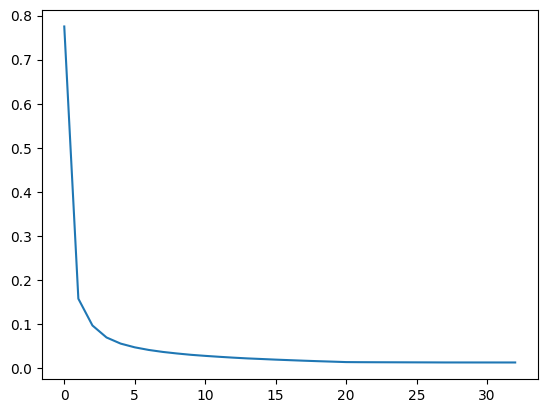

In [128]:
[print(h) for h in baseline_scores]
[plt.plot(h.history['loss']) for h in baseline_histories]

plt.show()

In [129]:
### model1
model1_results = [experiment(s, model1=True) for s in seeds]
model1_scores = [r[0] for r in model1_results]
model1_histories = [r[1] for r in model1_results]

Model: "model_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_55 (InputLayer)       [(None, 249)]             0         
                                                                 
 embedding_54 (Embedding)    (None, 249, 100)          740600    
                                                                 
 bidirectional_60 (Bidirect  (None, 249, 128)          84480     
 ional)                                                          
                                                                 
 time_distributed_60 (TimeD  (None, 249, 46)           5934      
 istributed)                                                     
                                                                 
Total params: 831014 (3.17 MB)
Trainable params: 90414 (353.18 KB)
Non-trainable params: 740600 (2.83 MB)
_________________________________________________________________
Epoch 1/50
31/31 [

0.6798859874390651


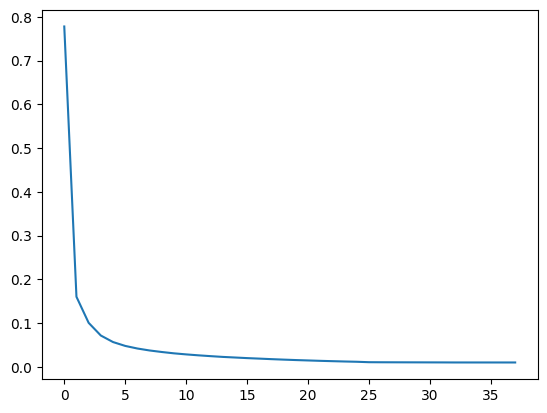

In [130]:
[print(h) for h in model1_scores]
[plt.plot(h.history['loss']) for h in model1_histories]
plt.show()

In [131]:
### model2
model2_results = [experiment(s, model2=True) for s in seeds]
model2_scores = [r[0] for r in model2_results]
model2_histories = [r[1] for r in model2_results]

Model: "model_55"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_56 (InputLayer)       [(None, 249)]             0         
                                                                 
 embedding_55 (Embedding)    (None, 249, 100)          740600    
                                                                 
 bidirectional_62 (Bidirect  (None, 249, 128)          84480     
 ional)                                                          
                                                                 
 time_distributed_61 (TimeD  (None, 249, 46)           5934      
 istributed)                                                     
                                                                 
 time_distributed_62 (TimeD  (None, 249, 46)           2162      
 istributed)                                                     
                                                          

0.7038820622239526


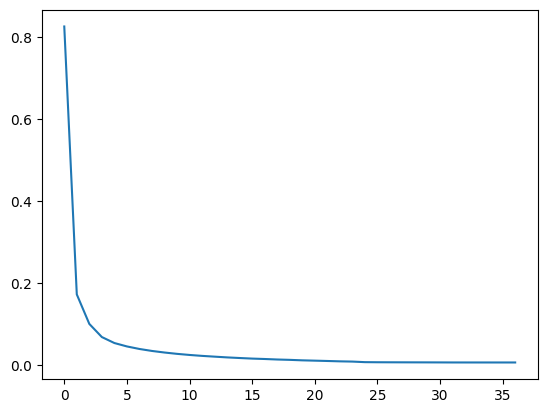

In [132]:
[print(h) for h in model2_scores]
[plt.plot(h.history['loss']) for h in model2_histories]
plt.show()

# [Task 6 - 1.0 points] Error Analysis

You are tasked to evaluate your best performing model.

### Instructions

* Compare the errors made on the validation and test sets.
* Aggregate model errors into categories (if possible)
* Comment the about errors and propose possible solutions on how to address them.

# [Task 7 - 1.0 points] Report

Wrap up your experiment in a short report (up to 2 pages).

### Instructions

* Use the NLP course report template.
* Summarize each task in the report following the provided template.

### Recommendations

The report is not a copy-paste of graphs, tables, and command outputs.

* Summarize classification performance in Table format.
* **Do not** report command outputs or screenshots.
* Report learning curves in Figure format.
* The error analysis section should summarize your findings.

# Submission

* **Submit** your report in PDF format.
* **Submit** your python notebook.
* Make sure your notebook is **well organized**, with no temporary code, commented sections, tests, etc...
* You can upload **model weights** in a cloud repository and report the link in the report.

# FAQ

Please check this frequently asked questions before contacting us

### Trainable Embeddings

You are **free** to define a trainable or non-trainable Embedding layer to load the GloVe embeddings.

### Model architecture

You **should not** change the architecture of a model (i.e., its layers).

However, you are **free** to play with their hyper-parameters.

### Neural Libraries

You are **free** to use any library of your choice to implement the networks (e.g., Keras, Tensorflow, PyTorch, JAX, etc...)

### Keras TimeDistributed Dense layer

If you are using Keras, we recommend wrapping the final Dense layer with `TimeDistributed`.

### Error Analysis

Some topics for discussion include:
   * Model performance on most/less frequent classes.
   * Precision/Recall curves.
   * Confusion matrices.
   * Specific misclassified samples.

### Punctuation

**Do not** remove punctuation from documents since it may be helpful to the model.

You should **ignore** it during metrics computation.

If you are curious, you can run additional experiments to verify the impact of removing punctuation.

# The End